In [1]:
#from multiprocessing import Pool
#from functools import partial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#from numba import jit

In [2]:
# loss of least square regression and binary logistic regression
'''`
    pred() takes GBDT/RF outputs, i.e., the "score", as its inputs, and returns predictions.
    g() is the gradient/1st order derivative, which takes true values "true" and scores as input, and returns gradient.
    h() is the heassian/2nd order derivative, which takes true values "true" and scores as input, and returns hessian.
    g and h are vectors of n_samples x 1
'''
class leastsquare(object):
    '''Loss class for mse. As for mse, pred function is pred=score.'''
    def pred(self,score):
        return score

    def g(self,true,score):
        return -2*(true-score)

    def h(self,true,score):    
        return 2*np.ones(len(true))

class logistic(object):
    '''Loss class for log loss. As for log loss, pred function is logistic transformation.'''
    def pred(self,score):
        classProb = 1/(1+np.exp(-score))
        pred = 1*(classProb > 0.5) # +-1 or 1 and 0??
        return pred

    def g(self,true,score):

        return -true/(np.exp(score)+1) + (1-true)/(np.exp(-score)+1)

        
    def h(self,true,score):
        
        return true*np.exp(score)*(np.exp(score)+1)**-2 + (1-true)*np.exp(-score)*(np.exp(-score)+1)**-2


In [3]:
# class of Random Forest
class RF(object):
    '''
    Class of Random Forest
    
    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth d_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule.
        num_trees: Number of trees.
    '''
    def __init__(self,
        n_threads = None, loss = 'mse',
        max_depth = 3, min_sample_split = 10, 
        lamda = 1, gamma = 0,
        rf = 0.99, num_trees = 100):
        
        self.n_threads = n_threads
        self.loss = loss
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = rf
        self.num_trees = num_trees
        
        #self-added
        self.model = []
        self.y_hat0_list = [] # store a list of y_hat0 to be used in prediction

    def fit(self, train, target):
        # train is n x m 2d numpy array
        # target is n-dim 1d array
        n,m = train.shape
        
        if self.loss == 'mse':
            errFn = leastsquare()
        else: 
            #log
            errFn = logistic()
        
        for k in range(self.num_trees): 
            rf_row_ind = np.random.choice(n, n, replace=True) # sampling with replacement from X
            samples_train = train[rf_row_ind, :]
            samples_target = target[rf_row_ind]
            self.y_hat0_list.append(np.float(np.mean(samples_target)))
                 
            g = errFn.g(samples_target, self.y_hat0_list[k]) #check see if scalar gets broadcasted
            h = errFn.h(samples_target, self.y_hat0_list[k])
  
            tree = Tree(n_threads = self.n_threads, max_depth = self.max_depth, 
                        min_sample_split = self.min_sample_split, 
                        lamda = self.lamda, gamma = self.gamma, rf = self.rf)
            
            tree.fit(samples_train, g, h)
            self.model.append(tree)
        
        return self.model

    def predict(self, test):
        n = test.shape[0]
        score = np.zeros((test.shape[0]))
        
        for ind, k in enumerate(self.model):

            score += (k.predict(test) + np.array(self.y_hat0_list[ind]))
        
        score /= self.num_trees
        
        if self.loss == 'mse':
            loss = leastsquare().pred(score)
            
        else: 
            #'log'
            loss = logistic().pred(score)

        return loss

In [28]:
# class of GBDT
class GBDT(object):
    '''
    Class of gradient boosting decision tree (GBDT)
    
    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth D_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        learning_rate: The learning rate eta of GBDT.
        num_trees: Number of trees.
    '''
    def __init__(self,
        n_threads = None, loss = 'mse',
        max_depth = 3, min_sample_split = 10, 
        lamda = 1, gamma = 0,
        learning_rate = 0.1, num_trees = 100):
        
        self.n_threads = n_threads
        self.loss = loss
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.num_trees = num_trees
        
        self.model = []
        self.yhat_0 = 0

        
    def fit(self, train, target):
        # train is n x m 2d numpy array
        # target is n-dim 1d array
        
        self.yhat_0 = np.float(np.mean(target))
        prevPred = self.yhat_0
        
        if self.loss == 'mse':
            errFn = leastsquare()
        else: 
            #log
            errFn = logistic()
            
        for k in range(self.num_trees): 
            
            g = errFn.g(target, prevPred) #check see if scalar gets broadcasted
            h = errFn.h(target, prevPred)
            
            tree = Tree(n_threads = self.n_threads, max_depth = self.max_depth, 
                        min_sample_split = self.min_sample_split, 
                        lamda = self.lamda, gamma = self.gamma)
            
            tree.fit(train, g, h)
            
            currPred = tree.predict(train)
            prevPred += self.learning_rate*currPred
            
            self.model.append(tree)
        
        return self.model

    def predict(self, test): 
        predHist = self.yhat_0

        for k in self.model:
            
            predHist += self.learning_rate * k.predict(test)

        if self.loss == 'mse':
            loss = leastsquare().pred(predHist)  
        else: 
            #'log'
            loss = logistic().pred(predHist)
        
        return loss

In [5]:
# class of a node on a tree
class TreeNode(object):
    '''
    Data structure that are used for storing a node on a tree.
    
    A tree is presented by a set of nested TreeNodes,
    with one TreeNode pointing two child TreeNodes,
    until a tree leaf is reached.
    
    A node on a tree can be either a leaf node or a non-leaf node.
    '''

    def __init__(self, split_feat=0, split_thres=0):
#         [X1, X2, index_y, value_y] = split(X)
        
        self.left_child = None
        self.right_child = None
        self.split_feat = split_feat
        self.split_thres = split_thres
        self.weight = None
        self.is_leaf = False
        
    def forward(self, x):
        if x[self.split_feat] < self.split_thres:
            return self.left_child
        else:
            return self.right_child
    

In [6]:
# class of single tree
class Tree(object):
    '''
    Class of a single decision tree in GBDT

    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        max_depth: The maximum depth of the tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf prediction, also known as lambda.
        gamma: The regularization coefficient for number of TreeNode, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule,
            rf = 0 means we are training a GBDT.
    '''
    
    def __init__(self, n_threads = None, 
                 max_depth = 3, min_sample_split = 10,
                 lamda = 1, gamma = 0, rf = 0):
        self.n_threads = n_threads
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = rf
        self.int_member = 0
        self.root = TreeNode()

    def fit(self, train, g, h):
        '''
        train is the training data matrix, and must be numpy array (an n_train x m matrix).
        g and h are gradient and hessian respectively.
        '''
        # recursively construct a tree
        self.root = self.construct_tree(train, g, h)
        return self.root

    def predict(self,test):
        '''
        test is the test data matrix, and must be numpy arrays (an n_test x m matrix).
        Return predictions (scores) as an array.
        '''
        n,m = test.shape 
        result = []
        
        for ind in range(n):
            node = self.root #reset node reference
            
            while not (node.is_leaf):
                node = node.forward(test[ind,:])
                
            result.append(node.weight)
            
        return np.array(result)
    
    def construct_tree(self, train, g, h, depth=0):
        '''
        Tree construction, which is recursively used to grow a tree.
        First we should check if we should stop further splitting.
        
        The stopping conditions include:
            1. tree reaches max_depth $d_{max}$
            2. The number of sample points at current node is less than min_sample_split, i.e., $n_{min}$
            3. gain <= 0
        '''
        split_feat, split_thres, gain = self.find_best_decision_rule(train, g, h)
        node = TreeNode(split_feat=split_feat, split_thres=split_thres)
        
        if depth >= self.max_depth or train.shape[0] < self.min_sample_split or gain <= 0:
            node.is_leaf = True
            node.weight = -np.sum(g)/(np.sum(h)+self.lamda)
            
            return node
        
        data_L, data_R, g_L, g_R, h_L, h_R = self.split(train, split_feat, split_thres, g, h)
        
        node.left_child = self.construct_tree(data_L, g_L, h_L, depth+1)
        node.right_child = self.construct_tree(data_R, g_R, h_R, depth+1)
        
        return node

    def split(self, train, split_feat, split_thres, g, h):
        '''
        Return left_data and right_data splited based on split_feat and split_thres
        train is the training data assigned to node j
        '''
        left_ind = train[:,split_feat] < split_thres
        right_ind = ~left_ind
        
        data_L, g_L, h_L = train[left_ind,:], g[left_ind], h[left_ind]
        data_R, g_R, h_R = train[right_ind,:], g[right_ind], h[right_ind]
        
        return data_L, data_R, g_L, g_R, h_L, h_R
      
    def find_best_decision_rule(self, train, g, h):
        '''
        Return the best decision rule [feature, treshold], i.e., $(p_j, \tau_j)$ on a node j, 
        train is the training data assigned to node j
        g and h are the corresponding 1st and 2nd derivatives for each data point in train
        g and h should be vectors of the same length as the number of data points in train
        
        for each feature, we find the best threshold by find_threshold(),
        a [threshold, best_gain] list is returned for each feature.
        Then we select the feature with the largest best_gain,
        and return the best decision rule [feature, treshold] together with its gain.
        '''
        num_data, m = train.shape
        m_prime = range(m)
        gainList = []
            
        # random pick m' no replacement

        if self.rf != 0:
            rf_feat_ind = np.random.choice(m, round(self.rf*m), replace=False) # used to index cols of X
            m_prime = rf_feat_ind

        for i in m_prime:
            threshold, gain = self.find_threshold(g, h, train[:,i])
            gainList.append((i,threshold, gain))
        
        feature, threshold, gain = sorted(gainList, key=lambda x: x[2])[-1] 
        
        return feature, threshold, gain
    
    def find_threshold(self, g, h, train):
        '''
        Given a particular feature $p_j$,
        return the best split threshold $\tau_j$ together with the gain that is achieved.
        '''
        currBestGain = (0,0)
        sortData = np.sort(train) #return copy of sorted array
        
        for ind, _ in enumerate(sortData):
            if ind == len(sortData)-1:
                break
            
            tau = (sortData[ind] + sortData[ind+1])/2
            
            LInd = train < tau
            RInd = train >= tau
            G_L = np.sum(g[LInd])
            G_R = np.sum(g[RInd])
            H_L = np.sum(h[LInd])
            H_R = np.sum(h[RInd])
            
            gain = 0.5*(G_L**2/(H_L+self.lamda) + G_R**2/(H_R+self.lamda) - (G_L+G_R)**2/(H_L+H_R+self.lamda)) - self.gamma
            
            if gain > currBestGain[1]:
                currBestGain = (tau,gain)
        
        return currBestGain

In [7]:
# Evaluation functions (you can use code from previous homeworks)

# RMSE
def root_mean_square_error(pred, y):
    diff = pred - y
    rmse = np.sqrt(np.dot(diff,diff)/len(diff))
    return rmse

# precision
def accuracy(pred, y):
    return sum(np.equal(pred, y)) / float(len(y))

In [29]:
# TODO: GBDT regression on boston house price dataset

# load data
from sklearn import datasets
boston = datasets.load_boston()
X = boston.data
y = boston.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

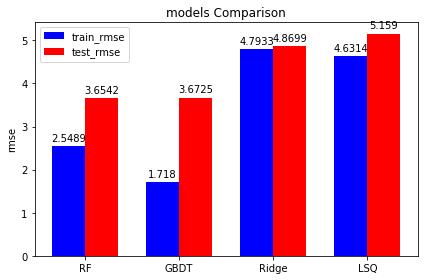

In [33]:
labels = ['RF', 'GBDT', 'Ridge', 'LSQ']
train_rmse = [2.5489299747298984, 1.7180395522565046, 4.793286773321472, 4.63142853427834]
test_rmse = [3.6541723648541904, 3.6724571158149026, 4.869926172571175, 5.159046200395644]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_rmse, width, label='train_rmse',color='blue')
rects2 = ax.bar(x + width/2, test_rmse, width, label='test_rmse',color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('rmse')
ax.set_title('models Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [32]:
# GBDT classification on credit-g dataset

# load data
from sklearn.datasets import fetch_openml
X, y = fetch_openml('credit-g', version=1, return_X_y=True, data_home='credit/')
y = np.array(list(map(lambda x: 1 if x == 'good' else 0, y)))

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1])

In [26]:
# GBDT classification on breast cancer dataset

# load data
from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [31]:
# Hyperparameters tuning
NUM = 1 #number of random combinations to search  
regress = False
# epislon = 0.1 #stop condition
# count = 0

if regress:
    loss = 'mse'
    init = 4.5
else:
    loss = 'log'
    init = 0.7

prevResult = dict({init:0})

for i in range(NUM):
    #common to both RF and GBDT
    gamma = np.asscalar(np.random.choice(np.linspace(0,1.0,11),1,replace=True))
    max_depth = int(np.random.choice(range(5,10),1,replace=True))
    min_sample = int(np.random.choice(range(1,30),1,replace=True))
    max_tree = int(np.random.choice(range(5,50),1,replace=True))
    lamda = np.asscalar(np.random.choice(np.arange(0.5,10.5,0.5),1,replace=True)) #[0,10]

    #GBDT specific
    eta = np.asscalar(np.random.choice(np.linspace(0.1,1,10),1,replace=True))

    #random forest specific
    m_prime = np.asscalar(np.random.choice(np.linspace(0.2,0.5,4),1,replace=True))  
    
    #RF
#     rf = RF(n_threads = None, loss = loss, max_depth = max_depth, 
#         min_sample_split = min_sample, lamda = lamda, gamma = gamma,
#         rf = m_prime, num_trees = max_tree)
    
#     rf_model = rf.fit(X_train,y_train)
    
#     train_pred = rf.predict(X_train)
#     test_pred = rf.predict(X_test)
    
    #GBDT
    gbdt = GBDT(n_threads = None, loss = loss,
        max_depth = max_depth, min_sample_split = min_sample, 
        lamda = lamda, gamma = gamma,
        learning_rate = eta, num_trees = max_tree)
    
    gbdt_model = gbdt.fit(X_train,y_train)
    
    train_pred = gbdt.predict(X_train)
    test_pred = gbdt.predict(X_test)
    
    if regress:
        train_rmse = root_mean_square_error(train_pred,y_train)
        test_rmse = root_mean_square_error(test_pred,y_test)
        print(f'train_rmse: {train_rmse}')
        print(f'test_rmse: {test_rmse}')
        print('max_depth: %f, min_sample: %f, lamda: %f, gamma: %f, m_prime: %f, max_tree: %f, eta: %f'
              % (max_depth,min_sample,lamda,gamma,m_prime,max_tree,eta))
    else: 
        train_precision = accuracy(train_pred,y_train)
        test_precision = accuracy(test_pred,y_test)
        print(f'train_precision: {train_precision}')
        print(f'test_precision: {test_precision}')
        print('max_depth: %f, min_sample: %f, lamda: %f, gamma: %f, m_prime: %f, max_tree: %f, eta: %f'
              % (max_depth,min_sample,lamda,gamma,m_prime,max_tree,eta))
    
    print('')
    
    if regress:
        if [*prevResult][0] > train_rmse:
            
            prevResult = {train_rmse:[max_depth,min_sample,lamda,gamma,m_prime,max_tree,test_rmse,eta]} 
    else:
        if [*prevResult][0] < train_precision:
        
            prevResult = {train_precision:[max_depth,min_sample,lamda,gamma,m_prime,max_tree,test_precision,eta]} 

print('-----------------------------------------------')
print('best_rmse: ' ,[*prevResult][0])
print('best_params: ', list(prevResult.values()))

currPred: [ 0.45461918 -1.18298672  0.13158445 -0.84991567  0.21240307 -1.18298672
  0.21240307  1.01815879  0.04656975  0.21240307 -0.00317367  0.13158445
  1.01815879  0.04656975  0.04656975  0.45461918  0.45461918  1.01815879
 -0.84991567 -0.84991567 -0.84991567 -0.06362504  0.45461918  1.01815879
 -0.84991567  0.07358308  0.45461918  1.01815879  1.01815879  0.45461918
 -1.18298672  0.17869799  1.01815879  0.04656975  0.45461918 -1.18298672
 -1.18298672  1.01815879  0.45461918  1.01815879  1.01815879 -0.00317367
 -0.84991567 -1.18298672  0.21240307  0.13158445  0.21240307 -1.18298672
  0.21240307  1.01815879  1.01815879 -0.06362504  0.21240307 -1.18298672
 -1.18298672  0.45461918  0.45461918  1.01815879  0.45461918  0.17869799
  1.01815879 -1.18298672  0.04656975  0.13158445 -1.18298672  1.01815879
 -1.18298672  0.45461918 -0.002192   -1.18298672 -0.84991567 -0.84991567
  1.01815879  0.07358308  0.17869799 -0.84991567  1.01815879  1.01815879
  1.01815879 -0.84991567  0.04656975  1.0

currPred: [-0.04425748 -1.06386059  0.39310965 -0.73419045  0.0714567  -1.06386059
  0.39310965  0.96225976  0.12340316 -0.73419045 -0.00302671  0.39310965
  0.96225976  0.12340316  0.12340316  0.57131152  0.57131152  0.96225976
 -0.73419045  0.0714567  -0.73419045 -0.16181446  0.57131152  0.96225976
 -0.73419045  0.18113029  0.57131152  0.96225976  0.96225976 -0.04425748
 -1.06386059  0.17057109  0.96225976  0.12340316  0.57131152 -1.06386059
 -1.06386059  0.96225976  0.57131152  0.96225976  0.96225976 -0.00302671
  0.0714567  -1.06386059 -0.73419045  0.39310965 -0.73419045 -1.06386059
  0.39310965  0.96225976  0.96225976 -0.16181446  0.0714567  -1.06386059
 -1.06386059 -0.04425748  0.57131152  0.96225976 -0.04425748  0.17057109
  0.96225976 -1.06386059  0.12340316  0.39310965 -1.06386059  0.96225976
 -1.06386059 -0.04425748 -0.00212191 -1.06386059 -0.73419045 -0.73419045
  0.96225976  0.18113029  0.17057109 -0.73419045  0.96225976  0.96225976
  0.96225976 -0.73419045  0.12340316  0.9

currPred: [ 0.40877301 -0.09194862  0.12390213 -0.73174168  0.21406861 -1.09611782
  0.21406861  0.26709905  0.84033333  0.21406861 -0.09194862  0.12390213
  0.84033333  0.26709905  0.84033333  0.40877301  0.40877301  0.26709905
 -0.73174168 -0.73174168 -0.73174168  0.84033333  0.40877301  0.84033333
 -0.73174168  0.0648065   0.40877301  0.84033333  0.84033333  0.40877301
 -1.09611782  0.84033333  0.26709905  0.26709905  0.40877301 -0.09194862
 -0.09194862  0.26709905  0.40877301  0.84033333  0.84033333 -0.09194862
 -0.73174168 -1.09611782  0.21406861  0.12390213  0.21406861 -0.09194862
  0.21406861  0.84033333  0.84033333  0.26709905  0.21406861 -1.09611782
 -0.09194862  0.40877301  0.40877301  0.84033333  0.40877301  0.84033333
  0.84033333 -1.09611782  0.84033333  0.12390213 -1.09611782  0.84033333
 -1.09611782  0.40877301 -0.09194862 -1.09611782 -0.73174168 -0.73174168
  0.26709905  0.0648065   0.84033333 -0.73174168  0.84033333  0.26709905
  0.84033333 -0.73174168  0.84033333  0.8

currPred: [-0.96222509 -0.15739819  0.16569499 -0.52303789  0.52671179 -0.96222509
  0.52671179  0.8731426   0.00497984 -0.96222509  0.42744932  0.16569499
  0.8731426   0.00497984  0.00497984  0.52671179  0.20859182  0.8731426
 -0.52303789 -0.52303789  0.10567196 -0.06391011  0.20859182  0.8731426
 -0.96222509  0.42744932 -0.96222509  0.8731426   0.8731426  -0.01920575
 -0.96222509  0.13017256  0.8731426   0.00497984  0.20859182 -0.15739819
  0.42744932  0.8731426   0.52671179  0.8731426   0.8731426   0.42744932
 -0.52303789 -0.96222509 -0.09665924  0.16569499 -0.96222509 -0.15739819
  0.52671179  0.8731426   0.8731426  -0.06391011  0.52671179 -0.96222509
 -0.37244549 -0.96222509  0.42744932  0.8731426   0.20859182  0.13017256
  0.8731426  -0.96222509  0.00497984 -0.96222509 -0.96222509  0.8731426
 -0.96222509  0.20859182  0.42744932 -0.96222509 -0.52303789 -0.52303789
  0.8731426  -0.52303789  0.13017256 -0.96222509  0.8731426   0.8731426
  0.8731426  -0.52303789  0.00497984  0.87314

currPred: [-0.71345537 -0.15006326  0.48426499 -0.41673599  0.50050595 -0.71345537
  0.50050595  0.11152382  0.8467073  -0.71345537  0.4450847  -0.41673599
  0.8467073   0.11152382  0.8467073   0.50050595  0.48426499  0.11152382
  0.48426499 -0.26673676 -0.71345537 -0.16626757  0.48426499  0.8467073
 -0.71345537  0.4450847  -0.71345537  0.8467073   0.8467073  -0.71345537
 -0.71345537  0.50050595  0.11152382  0.11152382  0.48426499 -0.15006326
  0.4450847   0.11152382  0.50050595  0.8467073   0.8467073   0.4450847
 -0.26673676 -0.71345537 -0.71345537 -0.41673599 -0.71345537 -0.15006326
  0.50050595  0.8467073   0.8467073  -0.16626757  0.50050595 -0.71345537
 -0.38628942 -0.71345537  0.4450847   0.8467073  -0.26673676  0.4450847
  0.8467073  -0.71345537  0.8467073  -0.71345537 -0.71345537  0.8467073
 -0.71345537 -0.26673676  0.4450847  -0.71345537 -0.41673599 -0.41673599
  0.11152382  0.48426499  0.4450847  -0.71345537  0.8467073   0.11152382
  0.8467073  -0.41673599  0.8467073   0.84670

currPred: [ 0.2575046   0.11465773 -0.88699305 -0.88699305  0.62150375 -0.88699305
  0.62150375  0.71802479 -0.01920413 -0.88699305  0.33454445  0.11465773
  0.71802479 -0.01920413 -0.01920413  0.62150375  0.33454445  0.71802479
  0.62150375 -0.17864052 -0.88699305  0.71802479  0.62150375  0.71802479
 -0.88699305  0.33454445 -0.27694895  0.71802479  0.71802479 -0.27694895
 -0.27694895  0.71802479  0.71802479 -0.01920413  0.62150375 -0.27694895
 -0.88699305  0.71802479  0.62150375  0.71802479  0.71802479  0.33454445
  0.62150375 -0.27694895 -0.88699305 -0.88699305 -0.88699305 -0.27694895
  0.11465773  0.71802479  0.71802479  0.71802479  0.62150375 -0.27694895
 -0.88699305 -0.27694895  0.33454445  0.71802479 -0.17864052  0.71802479
  0.71802479  0.32892331 -0.01920413 -0.88699305  0.32892331  0.71802479
 -0.27694895  0.2575046  -0.88699305 -0.88699305 -0.17864052 -0.17864052
  0.71802479  0.33454445  0.71802479  0.32892331  0.71802479  0.71802479
  0.71802479 -0.88699305 -0.01920413  0.7

currPred: [-0.60744107 -0.14455793 -0.28574144 -0.28574144  0.46310477 -0.60744107
  0.46310477  0.75654599  0.75654599 -0.60744107  0.42337484 -0.28574144
  0.75654599  0.44874442 -0.38476123  0.46310477  0.28321082  0.75654599
 -0.28574144 -0.28574144 -0.60744107  0.44874442  0.28321082  0.75654599
 -0.60744107  0.42337484 -0.60744107  0.75654599  0.75654599 -0.60744107
 -0.60744107  0.46310477  0.75654599 -0.38476123  0.28321082 -0.14455793
  0.42337484  0.75654599  0.46310477  0.75654599  0.75654599  0.42337484
 -0.28574144 -0.60744107 -0.60744107 -0.28574144 -0.60744107 -0.14455793
  0.46310477  0.75654599 -0.38476123 -0.38476123  0.46310477 -0.60744107
 -0.37332674 -0.60744107  0.42337484  0.75654599  0.28321082  0.42337484
  0.75654599 -0.60744107 -0.38476123 -0.60744107 -0.60744107  0.75654599
 -0.60744107  0.28321082  0.42337484 -0.60744107 -0.28574144 -0.28574144
  0.44874442 -0.28574144  0.42337484 -0.60744107  0.75654599  0.75654599
  0.75654599 -0.28574144  0.75654599  0.7

currPred: [-0.55195555 -0.23626141  0.46445728 -0.36012343  0.44016098 -0.55195555
  0.44016098  0.71902988  0.71902988 -0.55195555  0.35492969 -0.36012343
  0.71902988  0.43370654 -0.36430925  0.44016098  0.46445728  0.71902988
  0.46445728 -0.2543166  -0.55195555  0.43370654  0.46445728  0.71902988
 -0.55195555  0.35492969 -0.55195555  0.71902988  0.71902988 -0.55195555
 -0.55195555  0.44016098  0.71902988 -0.36430925  0.46445728  0.35492969
  0.35492969  0.71902988  0.44016098  0.71902988  0.71902988  0.35492969
 -0.2543166  -0.55195555 -0.55195555 -0.36012343 -0.55195555  0.35492969
  0.44016098  0.71902988 -0.36430925 -0.36430925  0.44016098 -0.55195555
 -0.36392632 -0.55195555  0.35492969  0.71902988 -0.2543166   0.35492969
  0.71902988 -0.55195555 -0.36430925 -0.55195555 -0.55195555  0.71902988
 -0.55195555 -0.2543166   0.35492969 -0.55195555 -0.36012343 -0.36012343
  0.43370654  0.46445728  0.35492969 -0.55195555  0.71902988  0.71902988
  0.71902988 -0.36012343  0.71902988  0.7

currPred: [-0.50251331 -0.14967021 -0.25948112 -0.25948112  0.41847518 -0.50251331
  0.41847518  0.26501311  0.71343081 -0.50251331  0.39426816 -0.25948112
  0.71343081  0.26501311  0.71343081  0.41847518  0.26906976  0.18223771
 -0.25948112 -0.25948112 -0.50251331  0.71343081  0.26906976  0.71343081
 -0.50251331  0.39426816 -0.50251331  0.71343081  0.71343081 -0.50251331
 -0.50251331  0.41847518 -0.49204743 -0.49204743  0.26906976 -0.14967021
  0.39426816 -0.49204743  0.41847518  0.71343081  0.71343081  0.39426816
 -0.25948112 -0.50251331 -0.50251331 -0.25948112 -0.50251331 -0.14967021
  0.41847518  0.71343081  0.71343081 -0.49204743  0.41847518 -0.50251331
 -0.35476368 -0.50251331  0.39426816  0.71343081  0.26906976  0.39426816
  0.71343081 -0.50251331  0.71343081 -0.50251331 -0.50251331  0.71343081
 -0.50251331  0.26906976  0.39426816 -0.50251331 -0.25948112 -0.25948112
  0.26501311 -0.25948112  0.39426816 -0.50251331  0.71343081  0.26501311
  0.71343081 -0.25948112  0.71343081  0.7

currPred: [ 0.38312699  0.22730032 -0.5598459  -0.5598459  -0.5598459  -0.5598459
  0.22730032  0.56993491 -0.07529275 -0.5598459   0.04469788  0.22730032
  0.56993491 -0.07529275 -0.07529275  0.38312699  0.38312699  0.56993491
 -0.5598459  -0.5598459  -0.5598459   0.56993491  0.38312699  0.56993491
 -0.5598459   0.04469788  0.38312699  0.56993491  0.56993491  0.38312699
 -0.33183786  0.56993491  0.56993491 -0.07529275  0.38312699  0.19306954
 -0.5598459   0.56993491  0.38312699  0.56993491  0.56993491  0.04469788
 -0.5598459  -0.33183786 -0.5598459  -0.5598459  -0.5598459   0.19306954
  0.22730032  0.56993491  0.56993491  0.56993491 -0.5598459  -0.33183786
 -0.5598459   0.38312699  0.38312699  0.56993491  0.38312699  0.56993491
  0.56993491 -0.5598459  -0.07529275 -0.5598459  -0.5598459   0.56993491
 -0.33183786  0.38312699 -0.5598459  -0.5598459  -0.5598459  -0.5598459
  0.56993491  0.04469788  0.56993491 -0.5598459   0.56993491  0.56993491
  0.56993491 -0.5598459  -0.07529275  0.569

currPred: [-0.48319773 -0.48319773  0.62492121 -0.01186977  0.31524207 -0.48319773
  0.31524207  0.24685737  0.64935395 -0.48319773  0.29771123 -0.01186977
  0.64935395  0.24685737  0.64935395  0.62492121  0.62492121  0.17285079
 -0.37918053 -0.29556459 -0.48319773  0.64935395  0.31524207  0.64935395
 -0.48319773  0.29771123 -0.48319773  0.64935395  0.64935395 -0.48319773
 -0.48319773 -0.37918053 -0.48452573 -0.48452573  0.62492121 -0.48319773
 -0.48319773 -0.48452573  0.62492121  0.64935395  0.64935395  0.29771123
  0.62492121 -0.48319773  0.03919082  0.62492121 -0.48319773 -0.48319773
  0.62492121  0.64935395  0.64935395 -0.48452573  0.62492121 -0.48319773
 -0.48319773 -0.48319773  0.29771123  0.64935395  0.62492121  0.29771123
  0.64935395 -0.48319773  0.64935395 -0.48319773 -0.48319773  0.64935395
 -0.48319773 -0.37918053  0.03919082 -0.48319773 -0.19029783 -0.01186977
  0.24685737  0.62492121  0.29771123 -0.48319773  0.64935395  0.24685737
  0.64935395 -0.37918053  0.64935395  0.6

currPred: [ 0.5775921  -0.60388669  0.43221153 -0.31027238  0.38454024 -0.60388669
  0.38454024  0.65599439  0.65599439 -0.6258099   0.5775921  -0.31027238
  0.65599439  0.37309932 -0.3854734   0.38454024  0.43221153  0.65599439
  0.43221153 -0.24698708  0.5775921   0.37309932  0.43221153  0.65599439
 -0.1818609  -0.6258099   0.5775921   0.65599439  0.65599439 -0.21742575
 -0.60388669  0.38454024  0.65599439 -0.3854734   0.43221153  0.28568735
  0.5775921   0.65599439  0.38454024  0.65599439  0.65599439  0.5775921
 -0.24698708  0.5775921  -0.6258099  -0.31027238 -0.1818609  -0.6258099
  0.38454024  0.65599439 -0.3854734  -0.3854734   0.38454024 -0.21742575
 -0.6258099  -0.21742575 -0.6258099   0.65599439 -0.24698708  0.5775921
  0.65599439 -0.60388669 -0.3854734   0.5775921   0.5775921   0.65599439
 -0.6258099  -0.24698708  0.5775921  -0.60388669 -0.31027238 -0.31027238
  0.37309932  0.43221153  0.5775921   0.5775921   0.65599439  0.65599439
  0.65599439 -0.31027238  0.65599439  0.6559

currPred: [-0.28281516  0.23064824 -0.58589724 -0.58589724  0.12470339 -0.58589724
  0.23064824  0.22558634  0.6272126  -0.58589724  0.10658908  0.23064824
  0.6272126   0.22558634  0.6272126   0.35021696  0.35021696 -0.30959086
 -0.58589724  0.12470339 -0.58589724 -0.02387546  0.35021696  0.6272126
 -0.58589724  0.10658908  0.35021696  0.6272126   0.6272126   0.35021696
  0.24223026 -0.28281516 -0.30959086 -0.30959086  0.35021696  0.24223026
 -0.58589724 -0.30959086  0.35021696  0.6272126   0.6272126   0.10658908
  0.12470339  0.24223026 -0.58589724 -0.58589724 -0.58589724 -0.28281516
  0.23064824  0.6272126   0.6272126  -0.30959086  0.12470339 -0.28281516
 -0.58589724 -0.28281516 -0.28281516  0.6272126  -0.28281516 -0.28281516
  0.6272126   0.34420674 -0.02387546 -0.58589724  0.34420674  0.6272126
  0.35021696 -0.28281516 -0.58589724 -0.58589724  0.34420674 -0.58589724
  0.22558634  0.10658908  0.35021696  0.34420674  0.6272126   0.22558634
  0.6272126  -0.58589724  0.6272126   0.627

currPred: [ 0.51516092 -0.64792169  0.51516092 -0.25078867  0.39104129 -0.64792169
  0.39104129  0.47563351 -0.11651916 -0.34252097  0.51516092 -0.25078867
  0.47563351 -0.11651916 -0.11651916  0.51516092  0.51516092  0.47563351
 -0.34252097 -0.45571253  0.51516092  0.47563351  0.39104129  0.47563351
 -0.45571253  0.51516092  0.51516092  0.47563351  0.47563351  0.51516092
 -0.64792169  0.47563351  0.47563351 -0.11651916 -0.34252097  0.28027974
  0.51516092  0.47563351  0.51516092  0.47563351  0.47563351  0.51516092
  0.39104129  0.51516092 -0.34252097  0.51516092 -0.25078867  0.51516092
 -0.34252097  0.47563351  0.47563351  0.47563351  0.39104129  0.51516092
 -0.34252097  0.51516092  0.51516092  0.47563351 -0.34252097  0.47563351
  0.47563351 -0.64792169 -0.11651916  0.51516092  0.51516092  0.47563351
 -0.34252097 -0.34252097  0.51516092 -0.64792169 -0.34252097 -0.25078867
  0.47563351  0.51516092  0.47563351  0.51516092  0.47563351  0.47563351
  0.47563351 -0.25078867 -0.11651916  0.4

currPred: [ 0.48619668 -0.4915257   0.48619668 -0.4915257   0.48619668  0.33037761
  0.48619668  0.53381959  0.53381959 -0.4915257   0.48619668 -0.4915257
  0.53381959  0.34200739 -0.3834028   0.48619668  0.48619668  0.53381959
  0.1446016  -0.67727265  0.48619668  0.34200739  0.1446016   0.53381959
 -0.4915257  -0.53589453  0.33037761  0.53381959  0.53381959  0.48619668
 -0.67727265 -0.53589453  0.53381959 -0.3834028   0.1446016   0.20772908
 -0.67727265  0.53381959  0.48619668  0.53381959  0.53381959  0.48619668
  0.48619668  0.48619668 -0.53589453  0.48619668 -0.4915257  -0.67727265
 -0.53589453  0.53381959 -0.3834028  -0.3834028   0.48619668 -0.53589453
 -0.53589453  0.48619668  0.33037761  0.53381959  0.48619668  0.48619668
  0.53381959 -0.67727265 -0.3834028   0.48619668  0.20772908  0.53381959
 -0.53589453 -0.53589453  0.48619668 -0.4915257  -0.67727265 -0.4915257
  0.34200739 -0.53589453  0.48619668  0.33037761  0.53381959  0.53381959
  0.53381959  0.10681084  0.53381959  0.533

currPred: [-0.04672327  0.17042292 -0.04672327 -0.04672327 -0.04672327 -0.71267661
  0.27440776 -0.04672327 -0.71267661 -0.71267661  0.17042292  0.27440776
  0.17042292 -0.20122614  0.17042292  0.5250596   0.5250596   0.17042292
 -0.04672327 -0.04672327 -0.08821424  0.17042292  0.5250596   0.5250596
 -0.08821424  0.17042292 -0.20122614  0.5250596  -0.04672327 -0.20122614
  0.5250596   0.5250596   0.17042292  0.17042292  0.5250596   0.17042292
  0.17042292 -0.08821424  0.5250596   0.17042292  0.17042292  0.17042292
  0.17042292 -0.08821424  0.02727762 -0.04672327 -0.08821424  0.17042292
  0.27440776  0.17042292  0.17042292  0.17042292 -0.04672327  0.5250596
  0.17042292 -0.20122614 -0.20122614  0.5250596   0.5250596   0.5250596
  0.17042292 -0.08821424  0.17042292 -0.08821424 -0.71267661  0.17042292
 -0.71267661  0.5250596   0.17042292 -0.08821424 -0.04672327 -0.04672327
  0.5250596   0.17042292  0.5250596  -0.71267661  0.5250596   0.5250596
  0.5250596   0.17042292 -0.04672327  0.52505

currPred: [ 0.07448772  0.07448772  0.21528558  0.21528558  0.34005931 -0.63700475
  0.34005931 -0.1156079   0.57748324 -0.64587815  0.3149693   0.21528558
  0.57748324 -0.1156079  -0.03974599  0.34005931  0.3149693  -0.1156079
 -0.37856864  0.34005931  0.07448772  0.57748324  0.34005931  0.57748324
  0.07448772  0.3149693   0.07448772  0.57748324  0.57748324  0.07448772
  0.07448772 -0.18892891 -0.1156079  -0.1156079   0.21528558 -0.63700475
  0.07448772 -0.1156079   0.34005931  0.57748324  0.57748324  0.3149693
  0.34005931  0.07448772 -0.64587815  0.07448772  0.07448772 -0.64587815
  0.21528558  0.57748324 -0.03974599 -0.1156079   0.34005931  0.07448772
 -0.64587815  0.07448772  0.3149693   0.57748324  0.21528558  0.3149693
  0.57748324  0.07448772  0.57748324  0.07448772  0.07448772  0.57748324
 -0.64587815 -0.37856864  0.07448772 -0.63700475  0.21528558  0.21528558
 -0.1156079   0.3149693   0.3149693   0.07448772  0.57748324 -0.1156079
  0.57748324 -0.37856864  0.57748324  0.57748

currPred: [-0.26791548  0.14584502 -0.26791548 -0.42587172  0.38485884 -0.15181242
  0.38485884  0.38485884  0.38485884  0.38485884  0.14584502  0.38485884
  0.14584502 -0.19581403  0.14584502  0.48487644  0.48487644  0.14584502
 -0.26791548 -0.42587172 -0.42587172  0.14584502  0.48487644  0.48487644
 -0.26791548  0.14584502 -0.19581403  0.48487644 -0.26791548 -0.19581403
  0.48487644  0.48487644  0.14584502  0.14584502  0.48487644  0.14584502
  0.14584502 -0.42587172  0.48487644  0.14584502  0.14584502  0.14584502
  0.14584502 -0.42587172 -0.26791548  0.38485884 -0.26791548  0.14584502
  0.38485884  0.14584502  0.14584502  0.14584502  0.38485884  0.48487644
  0.14584502 -0.19581403 -0.19581403  0.48487644  0.48487644  0.48487644
  0.14584502 -0.42587172  0.14584502 -0.42587172 -0.42587172  0.14584502
 -0.15181242  0.48487644  0.14584502 -0.26791548 -0.42587172 -0.42587172
  0.48487644  0.14584502  0.48487644 -0.26791548  0.48487644  0.48487644
  0.48487644  0.14584502 -0.42587172  0.4

currPred: [ 0.47022831 -0.44726353  0.47022831 -0.44726353  0.26326364  0.47022831
  0.26326364  0.47622156  0.47622156 -0.44726353  0.47022831 -0.44726353
  0.47622156  0.30753837 -0.37679745  0.47022831 -0.11415381  0.47622156
 -0.46156015 -0.53348194  0.47022831  0.30753837  0.26326364  0.47622156
 -0.44726353  0.47022831  0.47022831  0.47622156  0.47622156  0.47022831
 -0.53348194 -0.46156015  0.47622156 -0.37679745 -0.46156015  0.20899638
 -0.53348194  0.47622156  0.47022831  0.47622156  0.47622156  0.47022831
  0.26326364  0.47022831 -0.46156015  0.47022831 -0.44726353 -0.53348194
 -0.46156015  0.47622156 -0.37679745 -0.37679745  0.47022831  0.47022831
  0.47022831  0.47022831  0.47022831  0.47622156  0.47022831  0.47022831
  0.47622156 -0.53348194 -0.37679745  0.47022831  0.20899638  0.47622156
  0.47022831 -0.46156015  0.47022831 -0.44726353 -0.53348194 -0.44726353
  0.30753837  0.47022831  0.47022831  0.47022831  0.47622156  0.47622156
  0.47622156  0.10099197  0.47622156  0.4

currPred: [ 0.03071363 -0.21938981  0.03071363  0.07753877 -0.54489129  0.31863796
  0.31863796 -0.2104622   0.31863796 -0.54489129  0.31863796  0.07753877
  0.31863796 -0.19084313 -0.21938981  0.61635918  0.61635918  0.31863796
  0.31863796 -0.54489129 -0.2104622   0.31863796  0.61635918  0.61635918
  0.03071363  0.31863796 -0.19084313  0.34572277  0.31863796 -0.19084313
 -0.17827203 -0.17827203  0.31863796  0.31863796  0.61635918  0.31863796
  0.31863796  0.31863796  0.61635918  0.31863796 -0.2104622   0.03071363
 -0.54489129  0.31863796  0.07753877  0.03071363  0.03071363  0.31863796
  0.31863796  0.31863796 -0.21938981  0.31863796  0.03071363 -0.17827203
 -0.54489129 -0.19084313 -0.19084313  0.34572277 -0.17827203 -0.17827203
  0.31863796  0.03071363 -0.2104622   0.03071363 -0.54489129  0.31863796
 -0.54489129 -0.17827203  0.31863796 -0.21938981 -0.54489129 -0.21938981
  0.61635918  0.31863796  0.61635918 -0.54489129  0.61635918  0.61635918
  0.34572277  0.07753877 -0.2104622   0.6

currPred: [ 0.39568382 -0.10802509  0.39568382 -0.10802509  0.35613811  0.39568382
  0.35613811  0.42563853  0.42563853 -0.5779659   0.15581104  0.21167456
  0.42563853  0.15581104  0.17804923  0.39568382  0.39568382  0.42563853
 -0.5779659  -0.43357913  0.39568382 -0.47720407  0.35613811  0.42563853
 -0.43357913  0.39568382 -0.47720407  0.42563853  0.42563853  0.39568382
 -0.47720407 -0.5779659   0.42563853  0.15581104  0.21167456 -0.47720407
  0.39568382  0.42563853  0.15581104  0.42563853  0.42563853  0.15581104
  0.35613811 -0.47720407 -0.5779659   0.39568382 -0.10802509  0.39568382
  0.21167456  0.42563853  0.42563853  0.15581104  0.39568382 -0.47720407
 -0.5779659  -0.47720407  0.39568382  0.42563853  0.39568382  0.39568382
  0.42563853  0.39568382  0.15581104 -0.47720407 -0.47720407  0.42563853
 -0.5779659  -0.5779659   0.39568382 -0.47720407  0.39568382 -0.10802509
 -0.47720407  0.39568382  0.39568382  0.39568382  0.42563853  0.42563853
  0.42563853 -0.5779659   0.42563853  0.4

currPred: [-0.24721608  0.24817763 -0.24721608 -0.24721608 -0.24721608 -0.24721608
  0.24817763 -0.24721608 -0.24721608 -0.24721608  0.17070196  0.24817763
  0.17070196 -0.1817011  -0.24721608  0.42386689  0.42386689 -0.24721608
 -0.24721608 -0.24721608 -0.24721608 -0.24721608  0.42386689  0.42386689
 -0.24721608  0.17070196 -0.1817011   0.42386689 -0.24721608 -0.1817011
  0.42386689  0.42386689  0.17070196  0.17070196  0.42386689 -0.24721608
 -0.24721608 -0.24721608  0.42386689  0.17070196  0.17070196  0.17070196
 -0.24721608 -0.24721608 -0.24721608 -0.24721608 -0.24721608 -0.24721608
  0.24817763  0.17070196 -0.24721608  0.17070196 -0.24721608  0.42386689
 -0.24721608 -0.1817011  -0.1817011   0.42386689  0.42386689  0.42386689
  0.17070196 -0.24721608  0.17070196 -0.24721608 -0.24721608  0.17070196
 -0.24721608  0.42386689 -0.24721608 -0.24721608 -0.24721608 -0.24721608
  0.42386689  0.17070196  0.42386689 -0.24721608  0.42386689  0.42386689
  0.42386689 -0.24721608 -0.24721608  0.42

currPred: [ 0.37117955 -0.09966739  0.37117955 -0.09966739  0.12998467  0.37117955
  0.12998467  0.40008959  0.40008959  0.12998467  0.13918839  0.12998467
  0.40008959  0.13918839  0.17694505  0.37117955  0.37117955  0.40008959
  0.12998467 -0.40825948  0.37117955 -0.43493555  0.12998467  0.40008959
 -0.40825948  0.37117955 -0.43493555  0.40008959  0.40008959  0.37117955
 -0.43493555  0.12998467  0.40008959  0.13918839  0.12998467 -0.43493555
  0.37117955  0.40008959  0.13918839  0.40008959  0.40008959  0.13918839
  0.12998467 -0.43493555  0.12998467  0.37117955 -0.09966739  0.37117955
  0.12998467  0.40008959  0.40008959  0.13918839  0.37117955 -0.43493555
 -0.64939814 -0.43493555  0.37117955  0.40008959  0.37117955  0.37117955
  0.40008959  0.37117955  0.13918839 -0.43493555 -0.43493555  0.40008959
  0.12998467  0.12998467  0.37117955 -0.43493555  0.37117955 -0.09966739
 -0.43493555  0.37117955  0.37117955  0.37117955  0.40008959  0.40008959
  0.40008959  0.12998467  0.40008959  0.4

currPred: [ 0.40401675 -0.52715567  0.40401675 -0.34577632  0.40401675 -0.52715567
  0.40401675  0.40401675  0.26778895 -0.34577632 -0.38662673 -0.34577632
  0.26778895  0.46214004  0.21622254  0.46214004  0.46214004  0.40401675
 -0.34577632 -0.34577632  0.40401675 -0.52715567  0.46214004  0.46214004
  0.40401675  0.26778895  0.46214004  0.13820529 -0.34577632  0.46214004
  0.13820529 -0.38162133  0.26778895 -0.52715567  0.46214004  0.19209977
  0.21622254  0.40401675  0.46214004  0.26778895  0.40401675  0.19209977
  0.40401675  0.19209977 -0.34577632  0.40401675 -0.28110404 -0.52715567
 -0.34577632  0.26778895 -0.28110404  0.19209977  0.40401675 -0.38162133
 -0.34577632 -0.38162133  0.13820529  0.13820529  0.13820529  0.13820529
  0.40401675  0.40401675 -0.52715567 -0.38662673  0.26778895  0.26778895
 -0.34577632  0.46214004  0.40401675 -0.28110404  0.40401675  0.26778895
  0.46214004 -0.34577632  0.46214004  0.26778895  0.46214004  0.46214004
  0.13820529 -0.34577632  0.26778895  0.4

KeyboardInterrupt: 

In [ ]:
## Housing price prediction
#RF                       
train_rmse: 2.5489299747298984
test_rmse: 3.6541723648541904
max_depth: 7.000000, min_sample: 19.000000, lamda: 1.500000, gamma: 0.600000, m_prime: 0.500000, max_tree: 32.000000
                        
#GBDT
train_rmse: 1.7180395522565046
test_rmse: 3.6724571158149026
max_depth: 7.000000, min_sample: 26.000000, lamda: 6.000000, gamma: 0.500000, m_prime: 0.400000, max_tree: 29.000000, eta:0.7

linear_train_rmse: 4.63142853427834
linear_test_rmse: 4.869926172571175
ridge_train_rmse: 4.793286773321472
ridge_test_rmse: 5.159046200395644
    
## Credit-g
#RF
train_precision: 0.8242857142857143
test_precision: 0.7933333333333333
max_depth: 7.000000, min_sample: 14.000000, lamda: 4.500000, gamma: 0.000000, m_prime: 0.500000, max_tree: 31.000000
#GBDT
train_precision: 0.84
test_precision: 0.7833333333333333
max_depth: 8.000000, min_sample: 19.000000, lamda: 8.500000, gamma: 1.000000, max_tree: 35.000000, eta: 0.300000

## Breast cancer
#RF
train_precision: 0.9798994974874372
test_precision: 0.9590643274853801
max_depth: 5.000000, min_sample: 7.000000, lamda: 3.500000, gamma: 0.900000, m_prime: 0.400000, max_tree: 24.000000
#GBDT
train_precision: 0.992462311557789
test_precision: 0.9707602339181286
max_depth: 6.000000, min_sample: 3.000000, lamda: 3.500000, gamma: 0.800000, max_tree: 30.000000, eta: 0.800000
